In [ ]:
import urllib.request

raw_url = "https://raw.githubusercontent.com/wwmill/PricePredictor/master/"

urllib.request.urlretrieve(raw_url+"algs.py", "algs.py")
urllib.request.urlretrieve(raw_url+"LEGO_capitol.npy", "LEGO_capitol.npy")

('LEGO_capitol.npy', <http.client.HTTPMessage at 0x7bc67d318e50>)

In [ ]:
!pip install darts
!pip install scikit-optimize scikit-learn

In [ ]:
import algs
import numpy as np
import matplotlib.pyplot as plt

Price Prediction for Future Prices (for practical use)

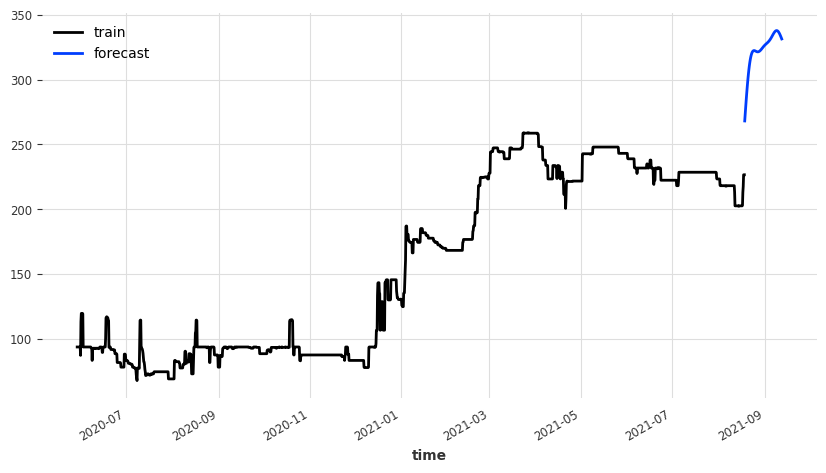

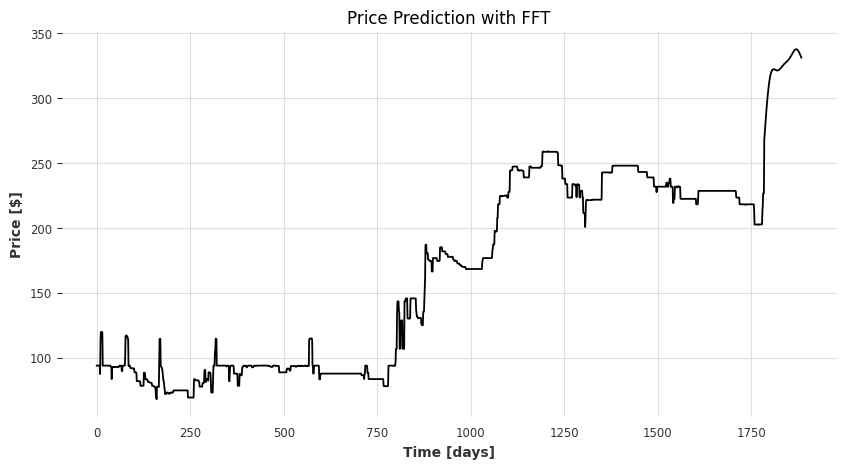

In [ ]:
# Enter File Location with npy array containing data after preprocessing
data = np.load('LEGO_capitol.npy')

# if you want to remove a certian number of points from the begnning and end of the data, change the num_chomp
# if you don't then set it to 0
num_chop = 0
prices = data[1,num_chop:data.shape[1]-num_chop]
time = data[0,num_chop:data.shape[1]-num_chop]

# you can choose which of the following algorithms to run
# See the README for what each input to the function is and which can be varied

#### SELECT ALGORITHM TO PERFORM ####
# result = algs.non_lin_reg(prices, time, 100, 1257, 20)
# result = algs.lstm_alg(prices, time, 50, 500, 10, 100, 1)
result = algs.fft_alg(prices, time, 100, 50)
# result = algs.ARMA_alg(prices[::50], 40)

Plotting the Full Dataset

Text(0, 0.5, 'Price [$]')

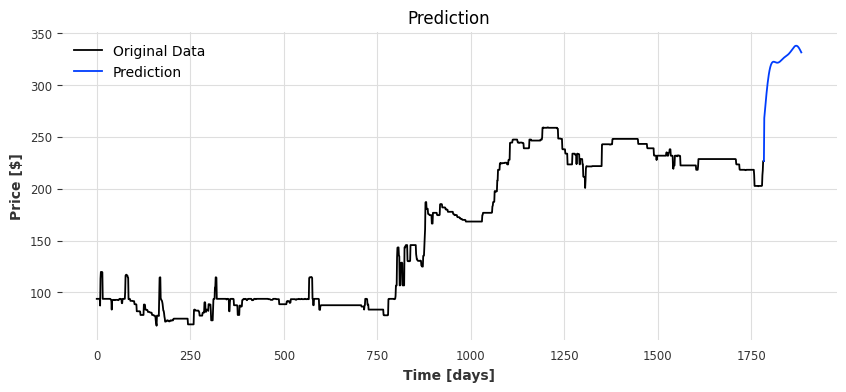

In [ ]:
prediction_y = result
len_original = prices.shape[0]
len_prediction = prediction_y.shape[0]
extend_prediction = np.zeros(len_original+len_prediction)
extend_prediction[:int(len_original-1)] = np.nan
extend_prediction[len_original-1] = prices[len_original-1] #add this line so that the orange line is continuous
extend_prediction[int(len_original):] = prediction_y[:]


fig = plt.figure(figsize = (10,4), facecolor = 'white')
ax = fig.add_subplot(111)
plt.plot(prices)
plt.plot(extend_prediction)
plt.legend(['Original Data', 'Prediction'])
plt.title('Prediction') # Enter Data Set name Here
plt.xlabel('Time [days]')
plt.ylabel('Price [$]')

# adjust the set_aspect to make the graph wider or narrower
# ax.set_aspect(1)

Price Predition with Test vs Train Dataset (for verifying performance)

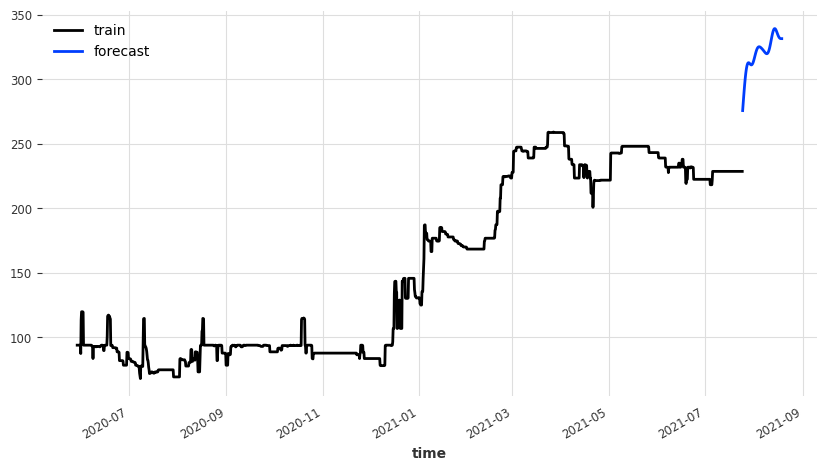

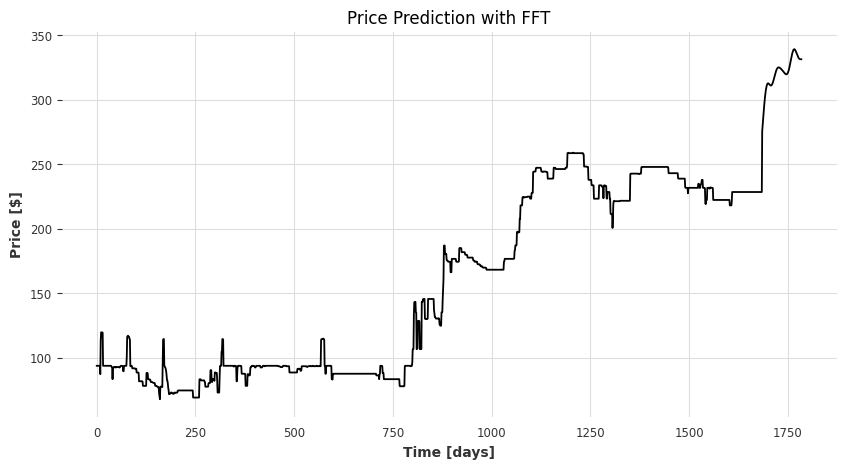

In [ ]:
import algs
import numpy as np
import matplotlib.pyplot as plt
data = np.load('LEGO_capitol.npy')

# if you want to remove a certian number of points from the begnning and end of the data, change the num_chomp
# if you don't then set it to 0
num_chop = 0
# number of points to test on
num_test_pts = 100

prices = data[1,num_chop:data.shape[1]-num_chop]
time = data[0,num_chop:data.shape[1]-num_chop]

size = len(prices)
train_p, test_p = prices[0:size-num_test_pts], prices[size-num_test_pts:]
train_t, test_t = time[0:size-num_test_pts], time[size-num_test_pts:]


######## SELECT ALGORITHM AND EVALUATION METRIC ########
# result = algs.non_lin_reg(train_p, train_t, num_test_pts, 1257, 20)
# result = algs.lstm_alg(train_p, train_t, num_test_pts, 500, 10, 100, 1)
result = algs.fft_alg(train_p, train_t, num_test_pts, 50)
# result = algs.ARMA_alg(train_p[::50], 40)

# if you want to get the RMSE of the data, comment whichever set you calcuated on
# print("RMSE For Non-Linar Reg: ", algs.rmse(result, test_p))
# print("RMSE For LSTM: ", algs.rmse(result, test_p))
# print("RMSE For FFT Forcasting: ", algs.rmse(result, test_p))
# print("RMSE for ARMA: ", algs.rmse(test_p[0], result))
#########################################################


Plotting the Training and Predicted Data

Text(0, 0.5, 'Price [$]')

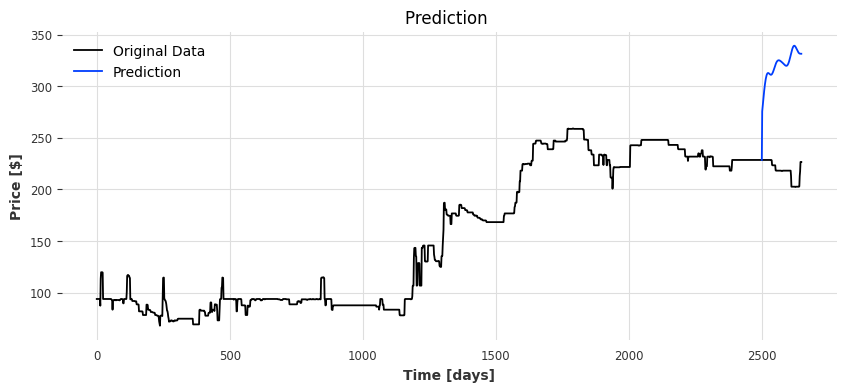

In [ ]:
prediction_y = result
len_original = prices.shape[0]
len_prediction = prediction_y.shape[0]
extend_prediction = np.zeros(len_original)
extend_prediction[:int(len_original-len_prediction-1)] = np.nan
extend_prediction[len_original-len_prediction-1] = prices[len_original-len_prediction-1] #add this line so that the orange line is continuous
extend_prediction[int(len_original-len_prediction):] = prediction_y[:]

fig = plt.figure(figsize = (10,4), facecolor = 'white')
ax = fig.add_subplot(111)
plt.plot(time,prices)
plt.plot(time,extend_prediction)
plt.legend(['Original Data', 'Prediction'])
plt.title('Prediction ')
plt.xlabel('Time [days]')
plt.ylabel('Price [$]')

# adjust the set_aspect to make the graph wider or narrower
# ax.set_aspect(10)


Optional - Bayesian Optimization of Parameters for LSTM

In [ ]:
import tensorflow as tf
from skopt import Optimizer
from skopt.space.space import Real, Integer
from skopt.plots import plot_gaussian_process, plot_objective
from sklearn.gaussian_process.kernels import Matern
from skopt.learning import GaussianProcessRegressor as GPR
import random
from datetime import datetime
import os

In [ ]:
data = np.load('LEGO_capitol.npy')

# BO LSTM
time = data[0, :2700]
prices = data[1, :2700]

tf.random.set_seed(0)

# BO Parameters
nBOiter = 5        # Total iterations (including initial pts)
n_init_pts = 2
nu = 2.5        # nu controls the smoothness of the matern kernel fitting for GP (e.g. nu = 1.5 corresponds to once differentiable functions, and nu = 2.5 to twice differentiable functions).

# Upper and Lower Bounds to Test
# look back
lower_back = 200
upper_back = 800
# look ahead
lower_ahead = 50
upper_ahead = 60
# Epochs
lower_epoch = 1
upper_epoch = 10
# Batch Size
lower_batch = 1
upper_batch = 256

# Define the Kernel
mat_kern = Matern(length_scale = 1, length_scale_bounds = (1, 10), nu = nu)
gpr = GPR(kernel = mat_kern, n_restarts_optimizer = 10)

# Define bounds for fit parameter
bounds = [Integer(lower_back, upper_back, name = 'back'), Integer(lower_ahead, upper_ahead, name = "ahead"), Integer(lower_epoch, upper_epoch, name = "epoch"), Integer(lower_batch, upper_batch, name = "batch")]
# initial_sampling = np.linspace(lower_bound,  upper_bound, n_init_pts)
init_pts_generator = 'grid'
kwargs = {'show_acq_func' :False, 'show_mu' :True, 'show_legend': False} # Optional arguments for plotting
# Optimizer for BO
rng_seed = int(datetime.now().strftime('%f'))
random.seed(rng_seed)
opt = Optimizer(bounds, base_estimator = gpr, acq_func = 'gp_hedge',n_initial_points = n_init_pts, initial_point_generator=init_pts_generator, acq_optimizer='sampling',random_state=rng_seed)


# intialize parameter history arrays
forecast_history = np.zeros(nBOiter)
lookback_history = np.zeros(nBOiter)
epochs_history = np.zeros(nBOiter)
batch_history = np.zeros(nBOiter)

prediction_y_collection = np.zeros([time.shape[0], nBOiter])

Epoch 1/6
9/9 - 19s - loss: 0.4094 - 19s/epoch - 2s/step
Epoch 2/6
9/9 - 9s - loss: 0.2182 - 9s/epoch - 957ms/step
Epoch 3/6
9/9 - 7s - loss: 0.0849 - 7s/epoch - 738ms/step
Epoch 4/6
9/9 - 9s - loss: 0.0256 - 9s/epoch - 952ms/step
Epoch 5/6
9/9 - 7s - loss: 0.0121 - 7s/epoch - 738ms/step
Epoch 6/6
9/9 - 9s - loss: 0.0094 - 9s/epoch - 950ms/step
1/1 [==============================] - 1s 816ms/step
1436/1436 - 125s - loss: 0.0125 - 125s/epoch - 87ms/step
1/1 [==============================] - 1s 1s/step
Epoch 1/10
5/5 - 15s - loss: 0.5927 - 15s/epoch - 3s/step
Epoch 2/10
5/5 - 10s - loss: 0.4872 - 10s/epoch - 2s/step
Epoch 3/10
5/5 - 11s - loss: 0.2903 - 11s/epoch - 2s/step
Epoch 4/10
5/5 - 12s - loss: 0.1700 - 12s/epoch - 2s/step
Epoch 5/10
5/5 - 12s - loss: 0.0962 - 12s/epoch - 2s/step
Epoch 6/10
5/5 - 10s - loss: 0.0530 - 10s/epoch - 2s/step
Epoch 7/10
5/5 - 11s - loss: 0.0349 - 11s/epoch - 2s/step
Epoch 8/10
5/5 - 12s - loss: 0.0254 - 12s/epoch - 2s/step
Epoch 9/10
5/5 - 12s - loss: 

1/1 [==============================] - 1s 1s/step
          fun: 17.052534218578096
            x: [500, 55, 6, 128]
    func_vals: [ 1.705e+01  2.987e+01  1.927e+01  2.236e+01  9.182e+01]
      x_iters: [[500, 55, 6, 128], [200, 50, 1, 1], [782, 60, 10, 196], [228, 51, 10, 256], [798, 59, 1, 66]]
       models: [GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5),
                                        n_restarts_optimizer=10), GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5),
                                        n_restarts_optimizer=10), GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5),
                                        n_restarts_optimizer=10), GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5),
                                        n_restarts_optimizer=10)]
        space: Space([Integer(low=200, high=800, prior='uniform', transform='normalize'),
                      Integer(low=50, high=60, prior='uniform', transform='

Text(0.5, 1.0, 'Batch size used as BO Progresses')

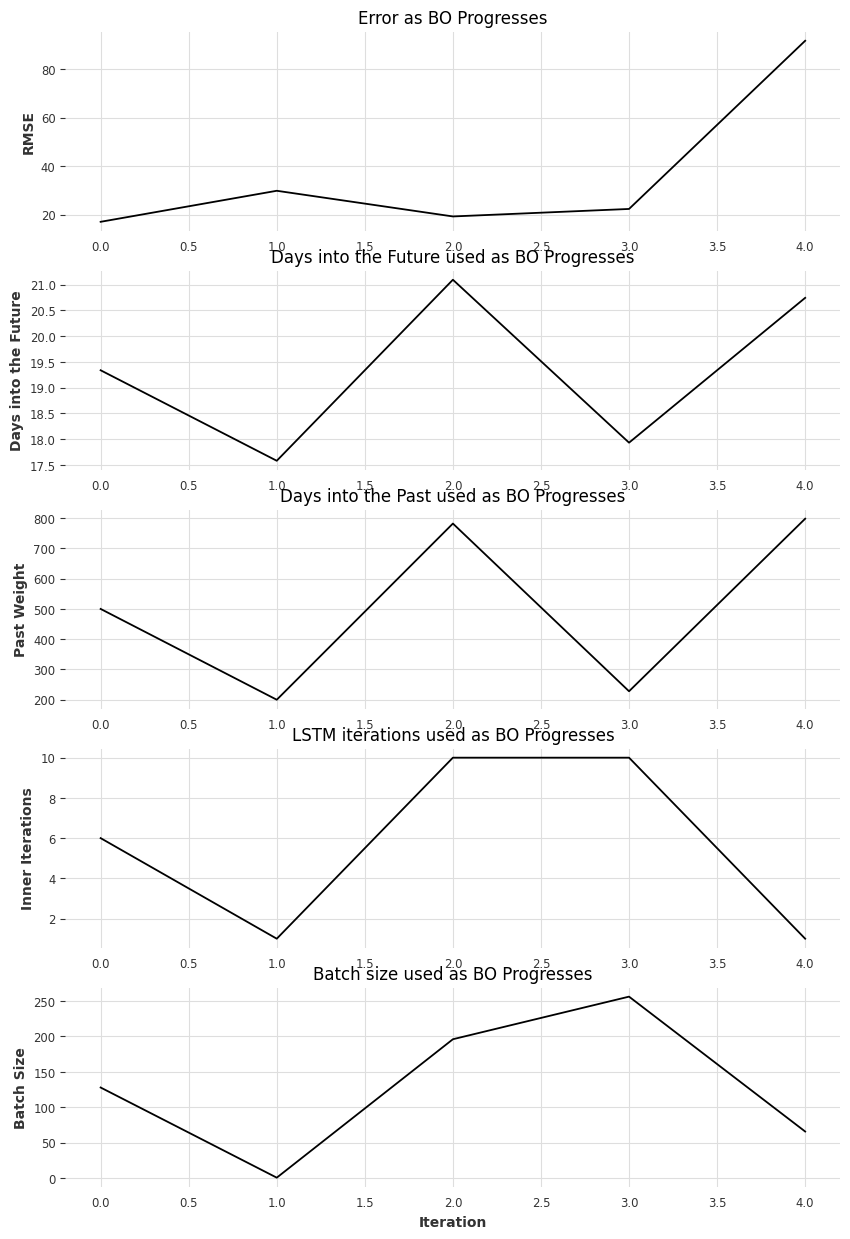

In [ ]:
for i in range(nBOiter):

    # Ask optimizer for next parameter to evaluate
    [n_lookback_next, n_forecast_next, epochs_next, batch_next] = opt.ask()
    # n_lookback_next = opt.ask()[1]  # length of input sequences (lookback period)
    forecast_history[i] = n_forecast_next
    lookback_history[i] = n_lookback_next
    epochs_history[i] = epochs_next
    batch_history[i] = batch_next
    # Perform reconstruction, evaluate the performance (this function call can be replaced for any general black box function of interest)
    y = prices[:(time.shape[0]-n_forecast_next)].reshape(-1,1) # congratulations you have found our easter egg!!
    prediction_y = algs.lstm_alg(y, time[:(time.shape[0]-n_forecast_next)], n_forecast_next, n_lookback_next, epochs_next, batch_next,0)
    len_prediction = prediction_y.shape[0]

    extend_prediction = np.zeros(len_original)
    extend_prediction[:int(len_original-len_prediction-1)] = np.nan
    extend_prediction[len_original-len_prediction-1] = prices[len_original-len_prediction-1] #add this line so that the orange line is continuous
    extend_prediction[int(len_original-len_prediction):] = prediction_y

    prediction_y_collection[:,i] = extend_prediction

    # calculate error
    data_error = algs.rmse(prediction_y, prices[prices.shape[0]-prediction_y.shape[0]:])

    # Tell the optimizer the result of the reconstruction
    res = opt.tell([n_lookback_next, n_forecast_next, epochs_next, batch_next], data_error)

    # Save data of interest:
    # reconstructor_object.save_results(save_directory+fname, output_name, i+1)          # Save 2D Slices from the Reconstruction
print(res)

fig_BO = plt.figure(figsize = (10,15))

plt.subplot(511)
plt.plot(res['func_vals'])
# plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Error as BO Progresses')
# plt.show()
# plt.axis('off')

plt.subplot(512)
plt.plot(forecast_history*1257/3575)
# plt.xlabel('Iteration')
plt.ylabel('Days into the Future')
plt.title('Days into the Future used as BO Progresses')
# plt.title('Optimization Process')
# plt.show()
# plt.axis('off')

plt.subplot(513)
plt.plot(lookback_history)
# plt.xlabel('Iteration')
plt.ylabel('Past Weight')
plt.title('Days into the Past used as BO Progresses')
# plt.title('Optimization Process')
# plt.show()
# plt.axis('off')

plt.subplot(514)
plt.plot(epochs_history)
# plt.xlabel('Iteration')
plt.ylabel('Inner Iterations')
plt.title('LSTM iterations used as BO Progresses')
# plt.title('Optimization Process')
# plt.show()
# plt.axis('off')

plt.subplot(515)
plt.plot(batch_history)
plt.xlabel('Iteration')
plt.ylabel('Batch Size')
plt.title('Batch size used as BO Progresses')
# plt.title('Optimization Process')
# plt.show()
# plt.axis('off')

    # Save plot of Bayesian Optimization
    # if i >= n_init_pts:
    #     plt.figure()
    #     plot_objective(res)     # Recreate Parameter Estimate Plots from Fig. 3a
        # plt.savefig(f'{save_directory}bo_gp{i+1}.png', transparent = False, bbox_inches = 'tight')